# Semantic Entropy Probes Training

Coding linear probes is easy - run logistic regression on saved hidden states from SE generations, and predict binarized SE labels and model correctness. We will replicate our experimental results in this notebook, and we share our example runs for Llama-2-7B short-form generations at [this project](https://wandb.ai/jiatongg/public_semantic_uncertainty) if you want a quick start. We keep some of our visualizations (for Llama2-7b, short-form generations, {NQ Open, TriviaQA, SQuAD, BioASQ}) for quick references.

For clarity, there are some variable naming conventions in this notebooks: `a` means accuracy, `b` means binarized entropy, `s` means SLT token, `t` means TBG token, `i` means In-Distribution (ID), `o` means Out-Of-Distribution (OOD).


This notebook is arranged in sections:
1) [Imports and Downloads](#Imports-and-Downloads) helps you load `wandb` runs into local storage;
2) [Data Preparation](#Data-Preparation) section prepares the training data, encapsulates the training and evaluation codes, and contains some visualization tools;
3) [Probing Acc/SE from Hidden States (id)](#Probing-Acc/SE-from-Hidden-States) section binarizes SE and carries out actual training of SEPs and Acc. Pr. in the In-Distribution setting, where we train and test on the same dataset yet on different splits;
4) [Test probes trained with one dataset on others](#Test-probes-trained-with-one-dataset-on-others) section tests SEPs and Acc. Pr. performances in predicting model correctness on other datasets;
5) The rest sections ([5](#Baselines-and-Performance-Plots), [6](#Save-trained-probes-for-inference)) are for performance comparisons with baselines and model saving.

## Imports and Downloads

In [ ]:
%load_ext autoreload
%autoreload 2

import json
import os
import pickle
import warnings
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy
import torch
import wandb
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
plt.rcParams.update({'font.size': 12})
rng = np.random.default_rng(42)
run_files = {
    'UNC_MEA': 'uncertainty_measures.pkl',
    'VAL_GEN': 'validation_generations.pkl', # essential for SEP training
    'WAN_SUM': 'wandb-summary.json'
}

In [ ]:
# TO FILL
model_name = 'Llama2-7b' # replace with your model name
ds_names = ['trivia-qa'] 
notebook_path = './' # replace with your notebook path

In [3]:
# ensure you are logged in before downloads
!wandb login

wandb: Currently logged in as: yancy123 (sdfsfdg). Use `wandb login --relogin` to force relogin


In [ ]:
# Paths need to contain 'validation_generations.pkl' and 'uncertainty_measures.pkl'
ds_paths = ['/home/semantic-entropy-probes/semantic_entropy_probes/wandb_runs/Llama2-7b/run-mb6th09c',]

## Data Preparation

In [6]:
# Create Dataset class for easier attribute keeping
class Dataset:
    def __init__(self, values):
        self.tbg_dataset = values[0]
        self.slt_dataset = values[1]
        self.entropy = values[2]
        self.accuracies = values[3]

def load_dataset(path, n_sample=2000):
    os.chdir(path)
    
    # Read validation generated embeddings
    with open(run_files['VAL_GEN'], 'rb') as f:
        generations = pickle.load(f)
    
    # Read uncertainty measures (p-true, predictive/semantic uncertainties)
    with open(run_files['UNC_MEA'], 'rb') as g:
        measures = pickle.load(g)

    # Attribute names are hardcoded into the files
    entropy = torch.tensor(measures['uncertainty_measures']['cluster_assignment_entropy']).to(torch.float32)
    
    accuracies = torch.tensor([record['most_likely_answer']['accuracy'] for record in generations.values()])
    
    # hidden states for TBG (token before model generation)
    tbg_dataset = torch.stack([record['most_likely_answer']['emb_last_tok_before_gen']
                               for record in generations.values()]).squeeze(-2).transpose(0, 1).to(torch.float32)
    
    # hidden states for SLT (second last token of model generation)
    slt_dataset = torch.stack([record['most_likely_answer']['emb_tok_before_eos']
                               for record in generations.values()]).squeeze(-2).transpose(0, 1).to(torch.float32)

    return (tbg_dataset[:, :n_sample, :], slt_dataset[:, :n_sample, :], entropy[:n_sample], accuracies[:n_sample])

In [12]:
# Load all datasets
Ds = []
for path in ds_paths:
    Ds.append(Dataset(load_dataset(path)))

# Set essential attributes for prettier printing
for i, D in enumerate(Ds):
    D.name = ds_names[i]
    D.path = ds_paths[i]
    # OOD-related
    D.other_ids = [j for j in range(len(Ds)) if j != i]
    D.other_names = [ds_names[j] for j in D.other_ids]

## Probing Acc/SE from Hidden States

### Helper methods

In [ ]:
# Create train/val/test splits
def create_Xs_and_ys(datasets, scores, val_test_splits=[0.2, 0.1], test_only=False, no_val=False):
    # Data splitting for sklearn linear models
    X = np.array(datasets)
    y = np.array(scores)

    if test_only:
        X_tests, y_tests = [], []
        
        for i in range(X.shape[0]):
            X_tests.append(X[i])
            y_tests.append(y)
        return (None, None, X_tests, None, None, y_tests)
    
    valid_size = val_test_splits[0]
    test_size = val_test_splits[1]
    
    X_trains, X_vals, X_tests, y_trains, y_vals, y_tests = [], [], [], [], [], []

    for i in range(X.shape[0]):
        # Split data into train, validation, and test sets
        X_train_val, X_test, y_train_val, y_test = train_test_split(X[i], y, test_size=test_size, random_state=42)
        X_tests.append(X_test)
        y_tests.append(y_test)
        if no_val:
            X_trains.append(X_train_val)
            y_trains.append(y_train_val)
            continue
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=valid_size, random_state=42)
        X_trains.append(X_train)
        y_trains.append(y_train)
        X_vals.append(X_val)
        y_vals.append(y_val)

    return X_trains, X_vals, X_tests, y_trains, y_vals, y_tests


In [14]:
# Bootstrapping methods from ../semantic_entropy/uncertainty/utils/eval_utils.py
def bootstrap_func(y_true, y_score, func):
    y_tuple = (y_true, y_score)
    
    metric_i = func(*y_tuple)
    metric_dict = {}
    metric_dict['mean'] = metric_i
    metric_dict['bootstrap'] = compatible_bootstrap(
        func, rng)(*y_tuple)  # a bit slow to run

    return metric_dict

def bootstrap(function, rng, n_resamples=1000):
    def inner(data):
        bs = scipy.stats.bootstrap(
            (data, ), function, n_resamples=n_resamples, confidence_level=0.9,
            random_state=rng)
        return {
            'std_err': bs.standard_error,
            'low': bs.confidence_interval.low,
            'high': bs.confidence_interval.high
        }
    return inner

def auroc(y_true, y_score):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    del thresholds
    return metrics.auc(fpr, tpr)

def compatible_bootstrap(func, rng):
    def helper(y_true_y_score):
        # this function is called in the bootstrap
        y_true = np.array([i['y_true'] for i in y_true_y_score])
        y_score = np.array([i['y_score'] for i in y_true_y_score])
        out = func(y_true, y_score)
        return out

    def wrap_inputs(y_true, y_score):
        return [{'y_true': i, 'y_score': j} for i, j in zip(y_true, y_score)]

    def converted_func(y_true, y_score):
        y_true_y_score = wrap_inputs(y_true, y_score)
        return bootstrap(helper, rng=rng)(y_true_y_score)
    return converted_func

In [ ]:
# Train and evaluation function.
def sklearn_train_and_evaluate(model, X_train, y_train, X_valid, y_valid, silent=False):
    model.fit(X_train, y_train)
    
    # Calculate training loss and score
    train_probs = model.predict_proba(X_train)
    train_loss = log_loss(y_train, train_probs)

    # Calculate validation loss
    valid_preds = model.predict(X_valid)
    valid_probs = model.predict_proba(X_valid)
    valid_loss = log_loss(y_valid, valid_probs)
    val_accuracy = np.mean((valid_preds == y_valid).astype(int))
    auroc_score = roc_auc_score(y_valid, valid_probs[:,1])
    if not silent:
        print(f"Validation Accuracy: {val_accuracy:.4f}, AUROC: {auroc_score:.4f}")
        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

def sklearn_evaluate_on_test(model, X_test, y_test, silent=False, bootstrap=True):
    test_preds = model.predict(X_test)
    test_probs = model.predict_proba(X_test)
    test_loss = log_loss(y_test, test_probs)
    test_accuracy = np.mean((test_preds == y_test).astype(int))
    
    if bootstrap:
        auroc_score = bootstrap_func(y_test, test_probs[:,1], auroc)
        auroc_score_scalar = auroc_score['mean']
    else:
        auroc_score = auroc_score_scalar = roc_auc_score(y_test, test_probs[:, 1])
    
    if not silent:
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, AUROC: {auroc_score_scalar:.4f}")
    
    return test_loss, test_accuracy, auroc_score

def train_single_metric(D, token_type='tbg', metric='b_entropy'):
    """train and test on single metric (e.g. SE, Acc) on single dataset"""
    var_name = token_type[0] + metric[0]
    # named as [te, se. ta, sa] for easy identification; t for tbg, s for slt (token positions)
    # e for entropy and a for accuracy (or model faithfulness)
    X_trains, X_vals, X_tests, y_trains, y_vals, y_tests = create_Xs_and_ys(
        getattr(D, f'{token_type}_dataset'), getattr(D, metric)
    )

    accs = []
    aucs = []
    models = []
    
    for i, (X_train, X_val, X_test, y_train, y_val, y_test) in enumerate(zip(X_trains, X_vals, X_tests, y_trains, y_vals, y_tests)):
        print(f"Training on {D.name}-{token_type.upper()}-{metric.upper()} {i+1}/{len(X_trains)}")
        model = LogisticRegression()
        sklearn_train_and_evaluate(model, X_train, y_train, X_val, y_val)
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(model, X_test, y_test)
        accs.append(test_acc)
        aucs.append(test_auc)
        models.append(model)

    setattr(D, f'{var_name}_accs', accs)
    setattr(D, f'{var_name}_aucs', aucs)
    setattr(D, f'{var_name}_models', models)

# simple get-around for unpacking bootstrapping dicts
auc = lambda aucs : [ac['mean'] for ac in aucs]
idf = lambda x : x  # identical function

In [16]:
# Plotting methods
def plot_metrics_ax(ax, test_metrics_list, model_names, title="", prep_func=auc, 
                    use_logarithm=False, preset_layer_indices=None, legend_outside=False):  # some simple gadgets
    """plot metrics along certain axis in a multi-axis plot (plt.subplots)"""
    if len(test_metrics_list) != len(model_names):
        raise ValueError("The length of test_metrics_list and model_names must be the same.")
    
    for test_metrics, model_name in zip(test_metrics_list, model_names):
        test_metrics = torch.tensor(prep_func(test_metrics), dtype=torch.float32)
        if use_logarithm:
            test_metrics = torch.log(test_metrics + 1e-6)
        if preset_layer_indices is not None:
            layer_indices = preset_layer_indices
        else:
            layer_indices = torch.arange(len(test_metrics)) + 1  # +1 if layer indexing starts at 1
        
        ax.plot(layer_indices, test_metrics, marker='o', linestyle='-', linewidth=2, markersize=5, label=model_name)
    
    ax.set_title(f'{title}', fontsize=14)
    ax.set_xlabel('Layer', fontsize=12)
    ax.set_ylabel(f'Test AUROC scores', fontsize=12)
    
    tick_interval = 5  # Change this value to display more or fewer ticks
    ax.set_xticks(layer_indices[::tick_interval].tolist())
    ax.set_xticklabels(layer_indices[::tick_interval].tolist())
    
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    if legend_outside:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
    else:
        ax.legend(fontsize=12)

def save_fig(name):
    """save figure with timestamps"""
    full_path = f'{notebook_path}/figures'
    full_path = os.path.expanduser(full_path)
    os.makedirs(full_path, exist_ok=True)
    plt.savefig(f'{full_path}/{name}.pdf', format='pdf', dpi=300)

In [ ]:
# Best split for SE binarization.
def best_split(entropy: torch.Tensor, label="Dx"):
    """
    Identify best split for minimizing reconstruction error via low and high SE mean estimates,
    as discussed in Section 4. Binarization of paper (ArXiv: 2406.15927)
    """
    ents = entropy.numpy()
    splits = np.linspace(1e-10, ents.max(), 100)
    split_mses = []
    for split in splits:
        low_idxs, high_idxs = ents < split, ents >= split

        low_mean = np.mean(ents[low_idxs])
        high_mean = np.mean(ents[high_idxs])

        mse = np.sum((ents[low_idxs] - low_mean)**2) + np.sum((ents[high_idxs] - high_mean)**2)
        mse = np.sum(mse)
    
        split_mses.append(mse)
    
    split_mses = np.array(split_mses)
    
    plt.plot(splits, split_mses, label=label)
    return splits[np.argmin(split_mses)]

def binarize_entropy(entropy, thres=0.0):  # 0.0 means even splits for normalized entropy scores
    """Binarize entropy scores into 0s and 1s"""
    binary_entropy = torch.full_like(entropy, -1, dtype=torch.float)
    binary_entropy[entropy < thres] = 0
    binary_entropy[entropy > thres] = 1

    return binary_entropy

### Binarize Semantic Entropy (SE)

We use `best-universal-split` in our experiments (see more details on binarization in Section 4 of [our paper](https://arxiv.org/pdf/2406.15927)).

Dummy accuracy for bioasq: 0.5255
Dummy accuracy for trivia-qa: 0.7625
Dummy accuracy for nq: 0.6090
Dummy accuracy for squad: 0.5765


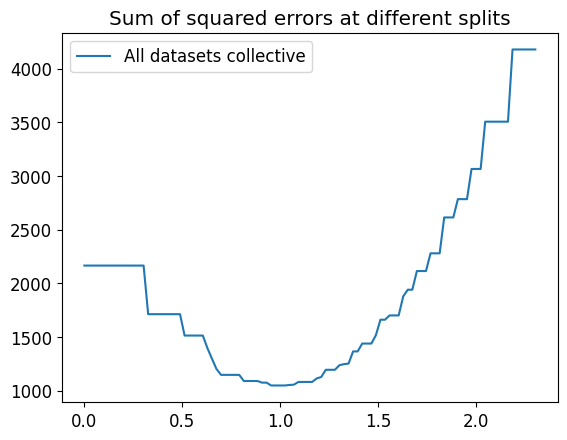

In [ ]:
# Best universal split across datasets
#split_method = 'best-universal-split'
all_entropy = torch.cat([D.entropy for D in Ds], dim=0)
split = best_split(all_entropy, "All datasets collective")
plt.legend()
plt.title('Sum of squared errors at different splits')
for D in Ds:
    D.b_entropy = binarize_entropy(D.entropy, split)
    print(f"Dummy accuracy for {D.name}: {max(torch.mean(D.b_entropy).item(), 1-torch.mean(D.b_entropy).item()):.4f}")

#### About trinarizing entropy: 

We can also leave out middle SE portion for better probing; we adopted this strategy for Llama2-70b long-form generation.


In [ ]:
def trinarize_entropy(entropy, thres1=0.639, thres2=1.478):
    """Trinarize entropy scores into 0's and 1's"""
    trinary_entropy = torch.full_like(entropy, -1, dtype=torch.float)
    trinary_entropy[entropy < thres1] = 0
    trinary_entropy[entropy > thres2] = 1
    return trinary_entropy

#split_method = 'tri-universal-split'
for D in Ds:
    D.t_entropy = t_entropy = trinarize_entropy(D.entropy, split, split)
    D.t_slt_dataset = D.slt_dataset[:, t_entropy != -1, :]
    D.t_tbg_dataset = D.tbg_dataset[:, t_entropy != -1, :]
    D.t_entropy = D.t_entropy[t_entropy != -1]
    D.t_accuracies = D.accuracies[t_entropy != -1]
    print('current left samples:', len(D.t_entropy))

current left samples: 2000
current left samples: 2000
current left samples: 2000
current left samples: 2000


### Train linear probes to predict Binarized SE

In [20]:
for D in Ds:
    train_single_metric(D, 'tbg', 'b_entropy')
    train_single_metric(D, 'slt', 'b_entropy')

Training on bioasq-TBG-B_ENTROPY 1/33
Validation Accuracy: 0.8361, AUROC: 0.8692
Training Loss: 0.3625, Validation Loss: 0.3897
Test Loss: 0.4164, Test Accuracy: 0.8000, AUROC: 0.8444
Training on bioasq-TBG-B_ENTROPY 2/33
Validation Accuracy: 0.8278, AUROC: 0.8935
Training Loss: 0.3150, Validation Loss: 0.3692
Test Loss: 0.4107, Test Accuracy: 0.7800, AUROC: 0.8637
Training on bioasq-TBG-B_ENTROPY 3/33
Validation Accuracy: 0.8306, AUROC: 0.8926
Training Loss: 0.2496, Validation Loss: 0.3696
Test Loss: 0.4251, Test Accuracy: 0.7750, AUROC: 0.8638
Training on bioasq-TBG-B_ENTROPY 4/33
Validation Accuracy: 0.8306, AUROC: 0.8989
Training Loss: 0.1875, Validation Loss: 0.3743
Test Loss: 0.4533, Test Accuracy: 0.8050, AUROC: 0.8646
Training on bioasq-TBG-B_ENTROPY 5/33
Validation Accuracy: 0.8167, AUROC: 0.8977
Training Loss: 0.1577, Validation Loss: 0.3848
Test Loss: 0.4504, Test Accuracy: 0.8100, AUROC: 0.8751
Training on bioasq-TBG-B_ENTROPY 6/33
Validation Accuracy: 0.8250, AUROC: 0.8948

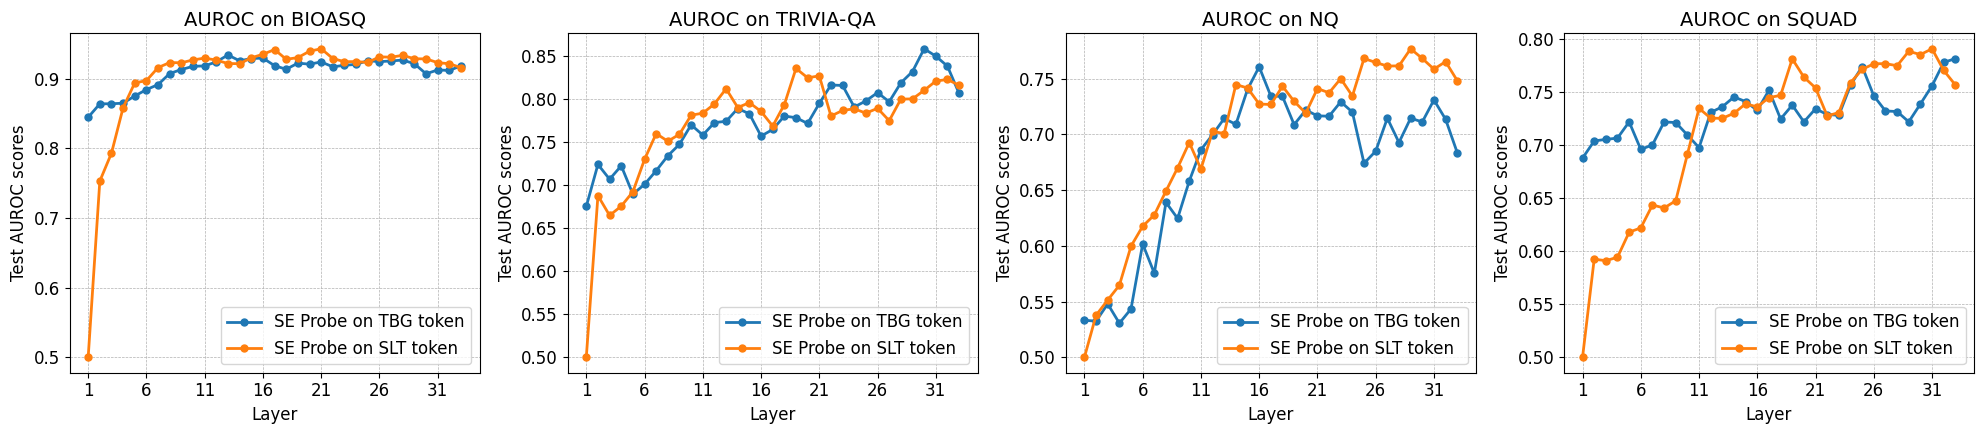

In [21]:
# plot se probe
fig, axs = plt.subplots(1, len(Ds), figsize=(5 * len(Ds), 4.5))
for i, D in enumerate(Ds):
    plot_metrics_ax(axs[i], [auc(D.tb_aucs), auc(D.sb_aucs)], ["SE Probe on TBG token", "SE Probe on SLT token"], 
                    f"AUROC on {D.name.upper()}", prep_func=idf)
plt.tight_layout()
save_fig(name="se_both_tok")
plt.show()

### Train linear probes to predict Accuracy

In [22]:
for D in Ds:
    train_single_metric(D, 'tbg', 'accuracies')
    train_single_metric(D, 'slt', 'accuracies')

Training on bioasq-TBG-ACCURACIES 1/33
Validation Accuracy: 0.7611, AUROC: 0.7582
Training Loss: 0.4736, Validation Loss: 0.5351
Test Loss: 0.4854, Test Accuracy: 0.8150, AUROC: 0.7771
Training on bioasq-TBG-ACCURACIES 2/33
Validation Accuracy: 0.7472, AUROC: 0.7614
Training Loss: 0.4390, Validation Loss: 0.5400
Test Loss: 0.4865, Test Accuracy: 0.8050, AUROC: 0.7936
Training on bioasq-TBG-ACCURACIES 3/33
Validation Accuracy: 0.7500, AUROC: 0.7482
Training Loss: 0.3791, Validation Loss: 0.5631
Test Loss: 0.5052, Test Accuracy: 0.7950, AUROC: 0.7982
Training on bioasq-TBG-ACCURACIES 4/33
Validation Accuracy: 0.7500, AUROC: 0.7633
Training Loss: 0.3207, Validation Loss: 0.5691
Test Loss: 0.5163, Test Accuracy: 0.7750, AUROC: 0.8007
Training on bioasq-TBG-ACCURACIES 5/33
Validation Accuracy: 0.7472, AUROC: 0.7729
Training Loss: 0.2882, Validation Loss: 0.5618
Test Loss: 0.5517, Test Accuracy: 0.7650, AUROC: 0.7934
Training on bioasq-TBG-ACCURACIES 6/33
Validation Accuracy: 0.7556, AUROC: 

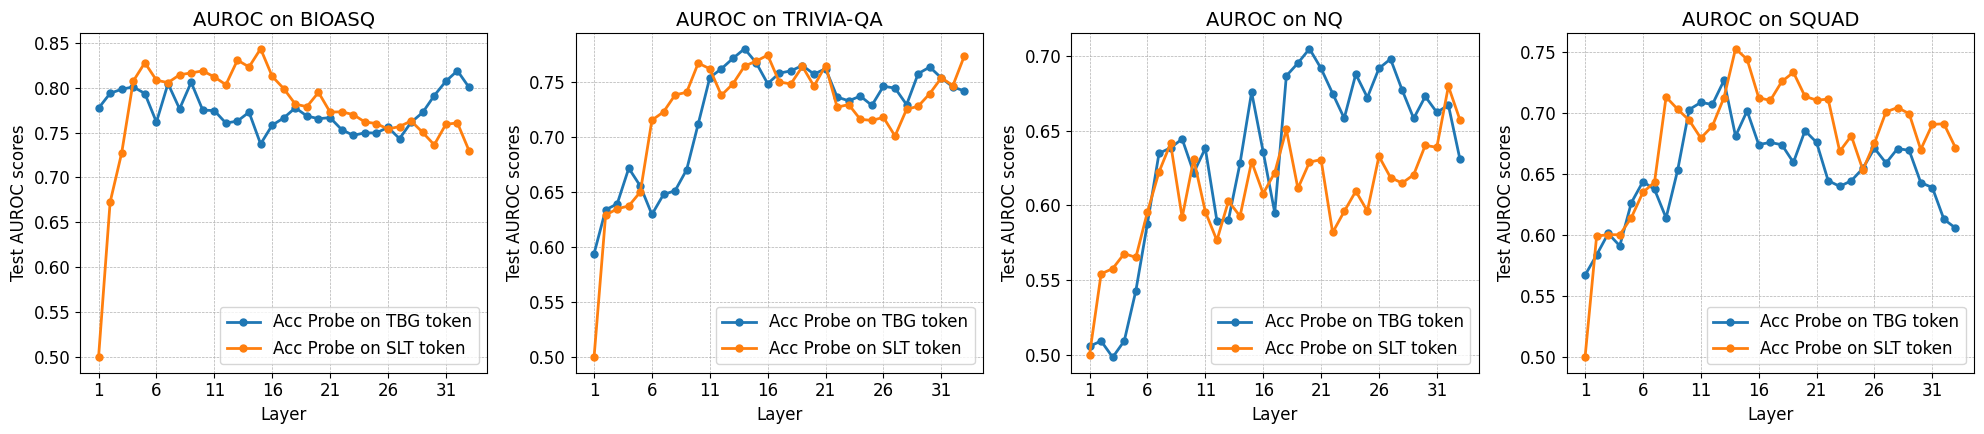

In [23]:
# plot acc probe
fig, axs = plt.subplots(1, len(Ds), figsize=(5 * len(Ds), 4.5))
for i, D in enumerate(Ds):
    plot_metrics_ax(axs[i], [auc(D.ta_aucs), auc(D.sa_aucs)], ["Acc Probe on TBG token", "Acc Probe on SLT token"], 
                    f"AUROC on {D.name.upper()}", prep_func=idf)
plt.tight_layout()
save_fig(name="acc_both_tok")
plt.show()

### Use linear probe trained on Binarized SE to predict Accuracy

We leverage trained probes on semantic entropy to predict model correctness on the same dataset.

Note that we need to predict the error rate (1 minus accuracy) using SEPs due to the nature of semantic uncertainty.

In [24]:
for D in Ds:
    r_acc = 1 - D.accuracies
    
    # TBG
    _, _, X_tests, _, _, y_tests = create_Xs_and_ys(D.tbg_dataset, r_acc) 
    tab_accs = []
    tab_aucs = []
    
    for i, (X_test, y_test) in enumerate(zip(X_tests, y_tests)):
        print(f"Testing on {D.name}-TBG {i+1}/{len(X_tests)}")
        model = D.tb_models[i]
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(model, X_test, y_test)
        tab_accs.append(test_acc)
        tab_aucs.append(test_auc)

    D.tab_accs = tab_accs
    D.tab_aucs = tab_aucs

    # SLT t
    _, _, X_tests, _, _, y_tests = create_Xs_and_ys(D.slt_dataset, r_acc)     
    sab_accs = []
    sab_aucs = []
    
    for i, (X_test, y_test) in enumerate(zip(X_tests, y_tests)):
        print(f"Testing on {D.name}-SLT {i+1}/{len(X_tests)}")
        model = D.sb_models[i]
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(model, X_test, y_test)
        sab_accs.append(test_acc)
        sab_aucs.append(test_auc)

    D.sab_accs = sab_accs
    D.sab_aucs = sab_aucs

Testing on bioasq-TBG 1/33
Test Loss: 0.6092, Test Accuracy: 0.7800, AUROC: 0.7899
Testing on bioasq-TBG 2/33
Test Loss: 0.6542, Test Accuracy: 0.7600, AUROC: 0.7669
Testing on bioasq-TBG 3/33
Test Loss: 0.7105, Test Accuracy: 0.7450, AUROC: 0.7807
Testing on bioasq-TBG 4/33
Test Loss: 0.7758, Test Accuracy: 0.7450, AUROC: 0.7722
Testing on bioasq-TBG 5/33
Test Loss: 0.8178, Test Accuracy: 0.7300, AUROC: 0.7741
Testing on bioasq-TBG 6/33
Test Loss: 0.9062, Test Accuracy: 0.7200, AUROC: 0.7656
Testing on bioasq-TBG 7/33
Test Loss: 0.9233, Test Accuracy: 0.7250, AUROC: 0.7779
Testing on bioasq-TBG 8/33
Test Loss: 0.9675, Test Accuracy: 0.7250, AUROC: 0.7801
Testing on bioasq-TBG 9/33
Test Loss: 1.0039, Test Accuracy: 0.7100, AUROC: 0.7901
Testing on bioasq-TBG 10/33
Test Loss: 0.9885, Test Accuracy: 0.7100, AUROC: 0.7978
Testing on bioasq-TBG 11/33
Test Loss: 1.0663, Test Accuracy: 0.7300, AUROC: 0.7991
Testing on bioasq-TBG 12/33
Test Loss: 1.1360, Test Accuracy: 0.7400, AUROC: 0.7985
T

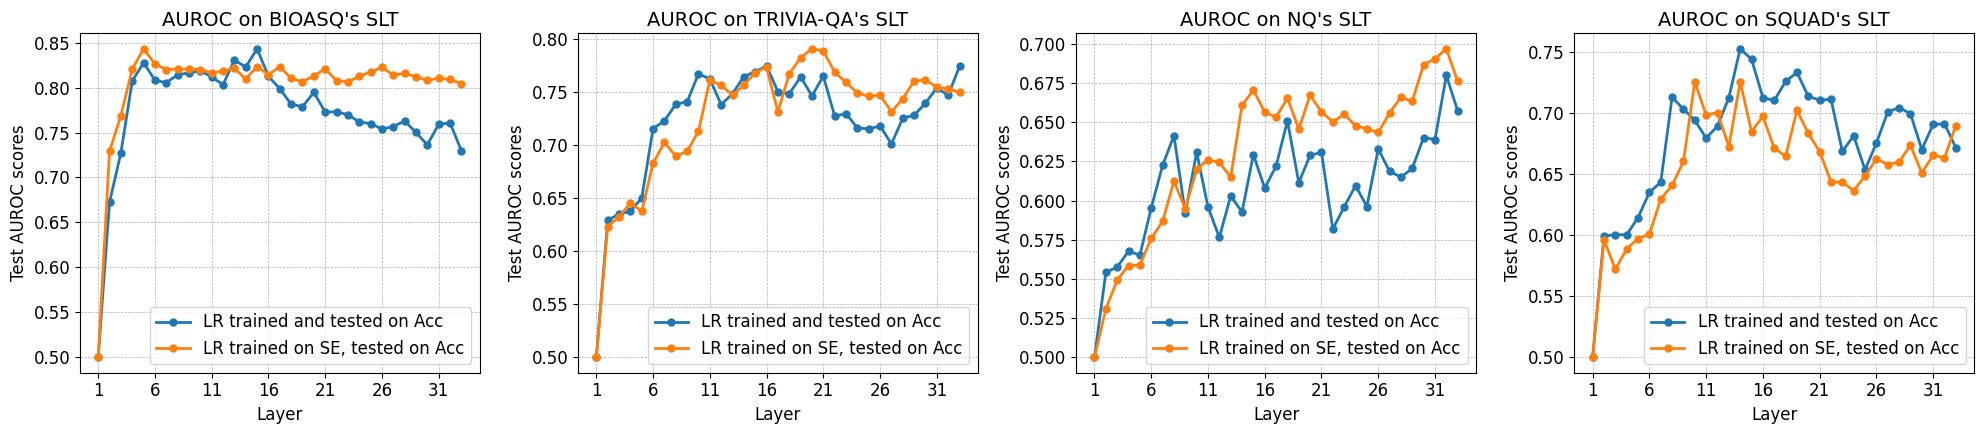

In [25]:
fig, axs = plt.subplots(1, len(Ds), figsize=(5 * len(Ds), 4.5))
for i, D in enumerate(Ds):
    plot_metrics_ax(axs[i], [D.sa_aucs, D.sab_aucs], ["LR trained and tested on Acc", "LR trained on SE, tested on Acc"], f"AUROC on {D.name.upper()}'s SLT")
plt.tight_layout()
save_fig(name="se_for_acc_slt")
plt.show()

In [26]:
# select best layer range (SLT)
def decide_layer_range(Ds, metric='entropy', limit=33): # NOTE: set upperbound to be number of layers+1; e.g. for llama2-70b, it is 81.
    """
    simple logic: use ID average test AUROCs across layers to determine 
    which consecutive range of layers did the best. Do separately
    for SEP and Acc. Pr.
    """
    assert hasattr(Ds[0], 'sab_aucs') and hasattr(Ds[0], 'sa_aucs'), 'previous cells need to be run'
    if 'entropy' in metric:
        aucs = [np.array(auc(D.sab_aucs)) for D in Ds]  # test metrics for ID SEPs
    else:
        aucs = [np.array(auc(D.sa_aucs)) for D in Ds]  # test metrics for ID APs
    best_mean = -np.inf
    best_range = []
    average = lambda a,b : np.mean([np.mean(ac[a:b]) for ac in aucs])

    for i in range(limit):
        for j in range(i+1, limit):
            if j - i < 5: # must be more than 5 layers
                continue
            if average(i, j) > best_mean:
                best_mean = average(i, j)
                best_range = [i, j]

    return best_mean, best_range

emean, (e1, e2) = decide_layer_range(Ds, 'entropy')
amean, (a1, a2) = decide_layer_range(Ds, 'acc')
for D in Ds:
    D.sep_layer_range = (e1, e2)
    D.ap_layer_range = (a1, a2)
print(emean, (e1, e2), amean, (a1, a2))

0.7328142326191573 (13, 21) 0.7306037548760836 (13, 18)


In [27]:
# BOOTSTRAP: select [xx-xx] layers for bootstrapping
def concat_Xs_and_ys(layer_range, X_trains, X_vals, X_tests, y_trains, y_vals, y_tests, 
                     no_val=False, test_only=False):
    """
    Concatenate @params{layer_range} hidden state layers on train/val/test sets.

    no_val: no validation (training set only).
    test_only: no train/validation set (test set only).
    """
    if not no_val:
        X_val_cc = np.concatenate(np.array(X_vals)[layer_range], axis=1)
        y_val_cc = y_vals[layer_range[0]]
    else:
        X_val_cc = y_val_cc = None

    if not test_only:
        X_train_cc = np.concatenate(np.array(X_trains)[layer_range], axis=1)
        y_train_cc = y_trains[layer_range[0]]
    else:
        X_train_cc = y_train_cc = None
    
    X_test_cc = np.concatenate(np.array(X_tests)[layer_range], axis=1)
    y_test_cc = y_tests[layer_range[0]]
    
    return X_train_cc, X_val_cc, X_test_cc, y_train_cc, y_val_cc, y_test_cc

def train_concat_SE(D, layer_range):
    """train model on single dataset SE with concatenated layers"""
    for token_type in ['slt']: # optionally, ['slt', 'tbg']
        var_name = token_type[0]
        all_Xs_and_ys = create_Xs_and_ys(getattr(D, f'{token_type}_dataset'), D.b_entropy, test_only=True) # train on all data
        _, _, X_train_cc, _, _, y_train_cc = concat_Xs_and_ys(layer_range, *all_Xs_and_ys, no_val=True, test_only=True)
        model = LogisticRegression()
        model.fit(X_train_cc, y_train_cc)
        setattr(D, f'{var_name}_bmodel', model)

        print(f'{token_type.upper()} trained on {D.name} SE finished')
    
def train_concat_Acc(D, layer_range):
    """train model on single dataset Accuracy with concatenated layers"""
    for token_type in ['slt']: # optionally, ['slt', 'tbg']
        var_name = token_type[0]
        all_Xs_and_ys = create_Xs_and_ys(getattr(D, f'{token_type}_dataset'), D.accuracies, test_only=True) # train on all data
        _, _, X_train_cc, _, _, y_train_cc = concat_Xs_and_ys(layer_range, *all_Xs_and_ys, no_val=True, test_only=True)
        model = LogisticRegression()
        model.fit(X_train_cc, y_train_cc)
        setattr(D, f'{var_name}_amodel', model)

        print(f'{token_type.upper()} trained on {D.name} Acc finished')

def train_concat_SE_Acc_test_Acc(D, layer_ranges=[list(range(e1,e2)), list(range(a1,a2))]):
    """ID: train and test SEPs and Acc. Pr. on single dataset with concatenated layers"""
    for token_type in ['slt']: # optionally, ['slt', 'tbg']
        var_name = token_type[0]
        all_Xs_and_ys = create_Xs_and_ys(getattr(D, f'{token_type}_dataset'), D.b_entropy, no_val=True) 
        
        X_train_cc, _, _, y_train_cc, _, _ = concat_Xs_and_ys(layer_ranges[0], *all_Xs_and_ys, no_val=True)
        ab_accs = []
        ab_aucs = []
        model = LogisticRegression()
        model.fit(X_train_cc, y_train_cc)

        all_Xs_and_ys = create_Xs_and_ys(getattr(D, f'{token_type}_dataset'), D.accuracies) 
        _, _, X_test_cc, _, _, y_test_cc = concat_Xs_and_ys(layer_ranges[0], *all_Xs_and_ys) # fixed random seed ensures no data leakage
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(model, X_test_cc, 1-y_test_cc) # SEP predicts error rate
        ab_accs.append(test_acc)
        ab_aucs.append(test_auc)
    
        setattr(D, f'i{var_name}b_accs', ab_accs)  # i means IDß
        setattr(D, f'i{var_name}b_aucs', ab_aucs)

        print(f'{D.name.upper()}-{token_type.upper()} trainied on SE and tested on Acc finished')
        aa_accs = []
        aa_aucs = []
        X_train_cc, _, X_test_cc, y_train_cc, _, y_test_cc = concat_Xs_and_ys(layer_ranges[1], *all_Xs_and_ys, no_val=True)
        model = LogisticRegression()
        model.fit(X_train_cc, y_train_cc)
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(model, X_test_cc, y_test_cc)
        aa_accs.append(test_acc)
        aa_aucs.append(test_auc)
    
        setattr(D, f'i{var_name}a_accs', aa_accs)
        setattr(D, f'i{var_name}a_aucs', aa_aucs)
        print(f'{D.name.upper()}-{token_type.upper()} trainied on Acc and tested on Acc finished')

In [28]:
# ID: train SEPs and Acc. Pr. and test them on Acc. from the same dataset
# import warnings # uncomment to disable convergence warnings
# warnings.filterwarnings('ignore')

for D in Ds:
    train_concat_SE_Acc_test_Acc(D)

Test Loss: 1.9072, Test Accuracy: 0.7550, AUROC: 0.8160
BIOASQ-SLT trainied on SE and tested on Acc finished
Test Loss: 0.9702, Test Accuracy: 0.7450, AUROC: 0.7971
BIOASQ-SLT trainied on Acc and tested on Acc finished
Test Loss: 1.7632, Test Accuracy: 0.6850, AUROC: 0.7837
TRIVIA-QA-SLT trainied on SE and tested on Acc finished
Test Loss: 0.9519, Test Accuracy: 0.7000, AUROC: 0.7726
TRIVIA-QA-SLT trainied on Acc and tested on Acc finished
Test Loss: 2.4475, Test Accuracy: 0.5700, AUROC: 0.6716
NQ-SLT trainied on SE and tested on Acc finished
Test Loss: 1.3951, Test Accuracy: 0.6500, AUROC: 0.6355
NQ-SLT trainied on Acc and tested on Acc finished
Test Loss: 1.4737, Test Accuracy: 0.6600, AUROC: 0.7132
SQUAD-SLT trainied on SE and tested on Acc finished
Test Loss: 0.8552, Test Accuracy: 0.7500, AUROC: 0.7423
SQUAD-SLT trainied on Acc and tested on Acc finished


In [29]:
# OOD: save model trained on individual datasets for OOD tests
for D in Ds:
    train_concat_SE(D, layer_range=list(range(e1,e2)))
    train_concat_Acc(D, layer_range=list(range(a1,a2)))
# outputs cleared for space concern

SLT trained on bioasq SE finished
SLT trained on bioasq Acc finished
SLT trained on trivia-qa SE finished
SLT trained on trivia-qa Acc finished
SLT trained on nq SE finished
SLT trained on nq Acc finished
SLT trained on squad SE finished
SLT trained on squad Acc finished


## Test probes trained with one dataset on others

We generalize SE and Acc. probes to Out-of-Distribution settings (OOD).

In [30]:
# Train on one's Acc/SE and test on others' Acc
def test_one_on_n(D, token_type='slt', 
                  layer_range1=list(range(e1,e2)), 
                  layer_range2=list(range(a1,a2))):
    var_name = token_type[0]
    other_ids = D.other_ids
    other_names = D.other_names
    metric = 'accuracies'
    a_model = getattr(D, f'{var_name}_amodel')  # Acc. Probe
    b_model = getattr(D, f'{var_name}_bmodel')  # SE Probe

    print(f"Using probes trained on datasets {D.name.upper()}'s {token_type.upper()}-SE/Acc to predict {other_names}'s {token_type.upper()}-Acc")

    oa_accs = {}
    oa_aucs = {}
    ob_accs = {}
    ob_aucs = {}
    
    for id_ in D.other_ids:
        D_id = Ds[id_]
        print(f"Testing on {D_id.name.upper()}'s {token_type.upper()}-{metric.upper()}")
        if metric == 'accuracies':
            y_metric = 1 - getattr(D_id, metric)  # error rate
        else:
            y_metric = getattr(D_id, metric)
        
        ida_accs = []
        ida_aucs = []
        idb_accs = []
        idb_aucs = []

        # create test sets with accuracy labels
        all_Xs_and_ys = create_Xs_and_ys(getattr(D_id, f'{token_type}_dataset'), y_metric, test_only=True)

        # test on Acc. Probes
        _, _, X_test_cc, _, _, y_test_cc = concat_Xs_and_ys(layer_range2, *all_Xs_and_ys, no_val=True, test_only=True)
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(a_model, X_test_cc, 1-y_test_cc, bootstrap=True)
        ida_accs.append(test_acc)
        ida_aucs.append(test_auc)
        
        # test on SE Probes
        _, _, X_test_cc, _, _, y_test_cc = concat_Xs_and_ys(layer_range1, *all_Xs_and_ys, no_val=True, test_only=True)
        test_loss, test_acc, test_auc = sklearn_evaluate_on_test(b_model, X_test_cc, y_test_cc, bootstrap=True)
        idb_accs.append(test_acc)
        idb_aucs.append(test_auc)

        oa_accs[D_id.name] = ida_accs
        oa_aucs[D_id.name] = ida_aucs
        ob_accs[D_id.name] = idb_accs
        ob_aucs[D_id.name] = idb_aucs

    setattr(D, 'osa_accs', oa_accs) # o means OOD
    setattr(D, 'osa_aucs', oa_aucs)
    setattr(D, 'osb_accs', ob_accs)
    setattr(D, 'osb_aucs', ob_aucs)

    print(f"Using probes trained on dataset {D.name.upper()} testing complete.")

In [31]:
for D in Ds:
    test_one_on_n(D, 'slt')

Using probes trained on datasets BIOASQ's SLT-SE/Acc to predict ['trivia-qa', 'nq', 'squad']'s SLT-Acc
Testing on TRIVIA-QA's SLT-ACCURACIES
Test Loss: 1.6577, Test Accuracy: 0.5810, AUROC: 0.6128
Test Loss: 1.9157, Test Accuracy: 0.6465, AUROC: 0.6906
Testing on NQ's SLT-ACCURACIES
Test Loss: 1.7527, Test Accuracy: 0.5535, AUROC: 0.5728
Test Loss: 2.5251, Test Accuracy: 0.4860, AUROC: 0.6571
Testing on SQUAD's SLT-ACCURACIES
Test Loss: 1.2898, Test Accuracy: 0.6640, AUROC: 0.6146
Test Loss: 2.1018, Test Accuracy: 0.5125, AUROC: 0.6440
Using probes trained on dataset BIOASQ testing complete.
Using probes trained on datasets TRIVIA-QA's SLT-SE/Acc to predict ['bioasq', 'nq', 'squad']'s SLT-Acc
Testing on BIOASQ's SLT-ACCURACIES
Test Loss: 2.0824, Test Accuracy: 0.5895, AUROC: 0.5286
Test Loss: 1.7502, Test Accuracy: 0.5640, AUROC: 0.6166
Testing on NQ's SLT-ACCURACIES
Test Loss: 1.4718, Test Accuracy: 0.6265, AUROC: 0.6374
Test Loss: 2.8851, Test Accuracy: 0.5355, AUROC: 0.6586
Testing 

In [32]:
# compute the OOD average: mean([train on B-> test on A, train on C -> test on A, train on D-> test on A])
b_performances = defaultdict(list)
a_performances = defaultdict(list)
win_rate = []
for D in Ds:
    for name in D.other_names:
        b_performances[name].append(auc(D.osb_aucs[name]))
        a_performances[name].append(auc(D.osa_aucs[name]))
        if auc(D.osb_aucs[name]) > auc(D.osa_aucs[name]):
            win_rate.append(1)
        else:
            win_rate.append(0)

print(f"winning rate: {np.mean(win_rate)*100:.2f}%")

for D in Ds:
    D.sep_ood_avg = np.mean(b_performances[D.name])
    D.ap_ood_avg = np.mean(a_performances[D.name])
    print(f"Average performance on {D.name}: SE Probe - {D.sep_ood_avg}, Acc Probe - {D.ap_ood_avg}")

winning rate: 100.00%
Average performance on bioasq: SE Probe - 0.6951997655122656, Acc Probe - 0.5703745039682541
Average performance on trivia-qa: SE Probe - 0.6747271671994248, Acc Probe - 0.6298524736436325
Average performance on nq: SE Probe - 0.6559901103822084, Acc Probe - 0.6099878306232117
Average performance on squad: SE Probe - 0.6369587855278028, Acc Probe - 0.5975129360258393


## Baselines and Performance Plots

Optional section for baselines and plotting barplots like in the paper.

Baselines include log-likelihoods, p-true, naive (predictive) entropy, and semantic entropy predicted model correctness, in the form of AUROC score.

In [33]:
# log likelihood baseline (a bit slow due to file loading)
for D in Ds:
    with open(f"{D.path}/{run_files['VAL_GEN']}", 'rb') as file:
        gens = pickle.load(file)
    liks = torch.tensor([np.mean(record['most_likely_answer']['token_log_likelihoods']) for record in gens.values()])
    accs = torch.tensor([record['most_likely_answer']['accuracy'] for record in gens.values()])
    probs = np.exp(liks)
    D.loglik = bootstrap_func(accs, probs, auroc)
    print(f"{D.name} log-lik: {D.loglik['mean']:.4f}")

bioasq log-lik: 0.5940
trivia-qa log-lik: 0.5586
nq log-lik: 0.5716
squad log-lik: 0.5650


In [34]:
# p_true and naive entropy baselines from uncertainty_measures and wandb_summary 
# You should've enabled `--compute_p_true` in generation runs.
for i, path in enumerate(ds_paths):
    os.chdir(path)

    # no need to run again once collected
    if hasattr(Ds[i], 'p_false_fixed') and hasattr(Ds[i], 'baseline_se'):
        continue

    with open(run_files['UNC_MEA'], 'rb') as file:
        measures = pickle.load(file)

    p_false_fixed_tuple = (measures['validation_is_false'], measures['uncertainty_measures']['p_false_fixed'])

    metric_i = auroc(*p_false_fixed_tuple)
    p_false_fixed_dict = {}
    p_false_fixed_dict['mean'] = metric_i
    p_false_fixed_dict['bootstrap'] = compatible_bootstrap(
        auroc, rng)(*p_false_fixed_tuple)  # a bit slow to run

    Ds[i].p_false_fixed = p_false_fixed_dict

    with open(run_files['WAN_SUM'], 'rb') as file:  # auto-collected with analyze_run.py
        boots = json.load(file)

    Ds[i].baseline_se = boots['uncertainty']['cluster_assignment_entropy']['AUROC']
    Ds[i].baseline_re = boots['uncertainty']['regular_entropy']['AUROC']

    print(f"Baselines for {Ds[i].name} computed.")

Baselines for bioasq computed.
Baselines for trivia-qa computed.
Baselines for nq computed.
Baselines for squad computed.


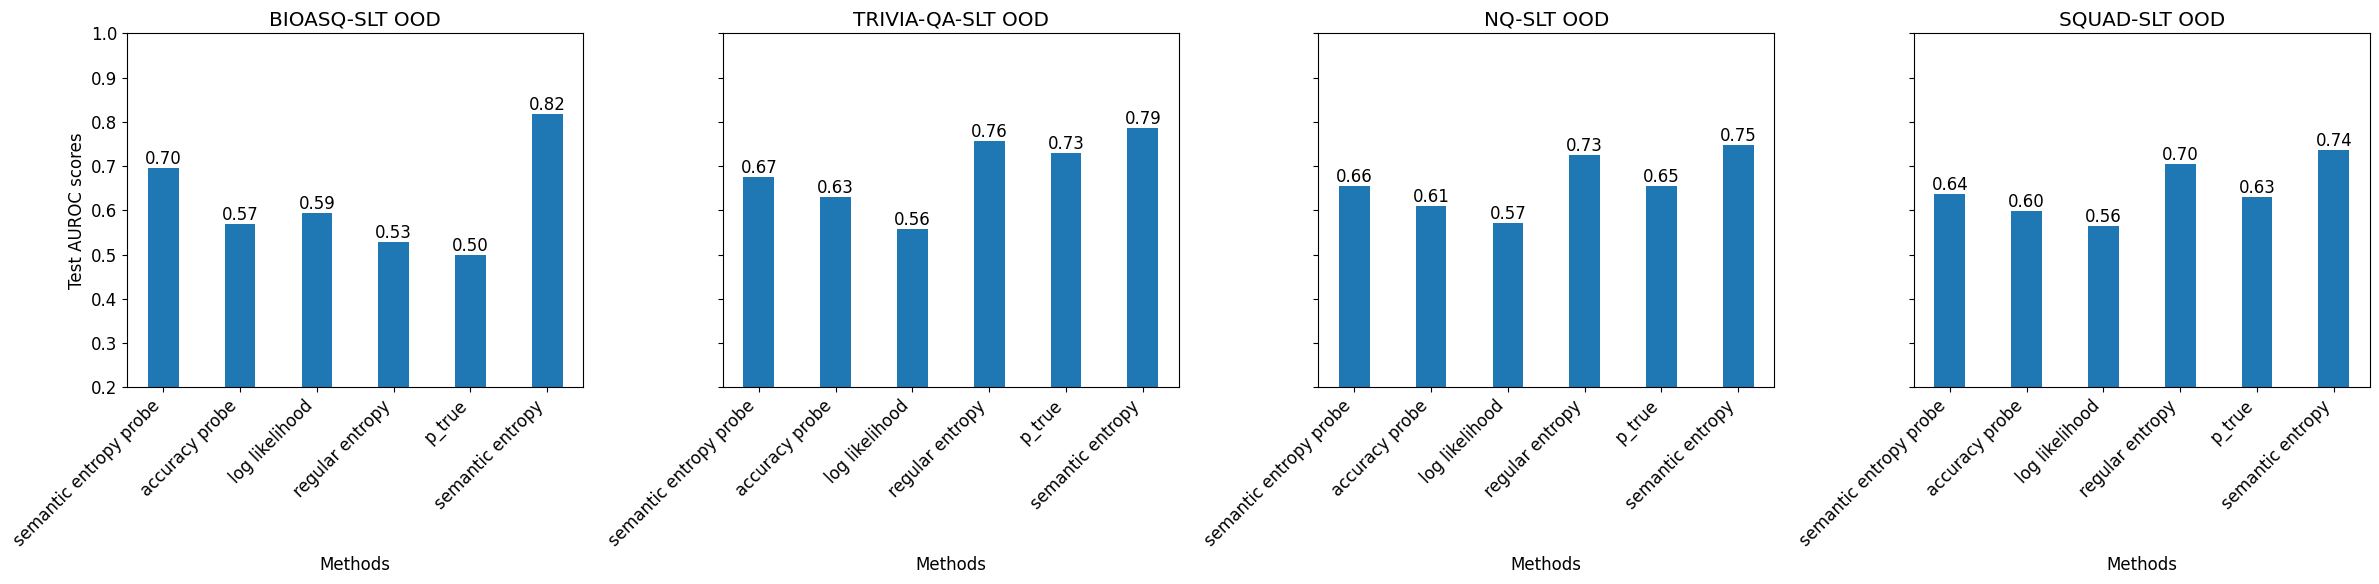

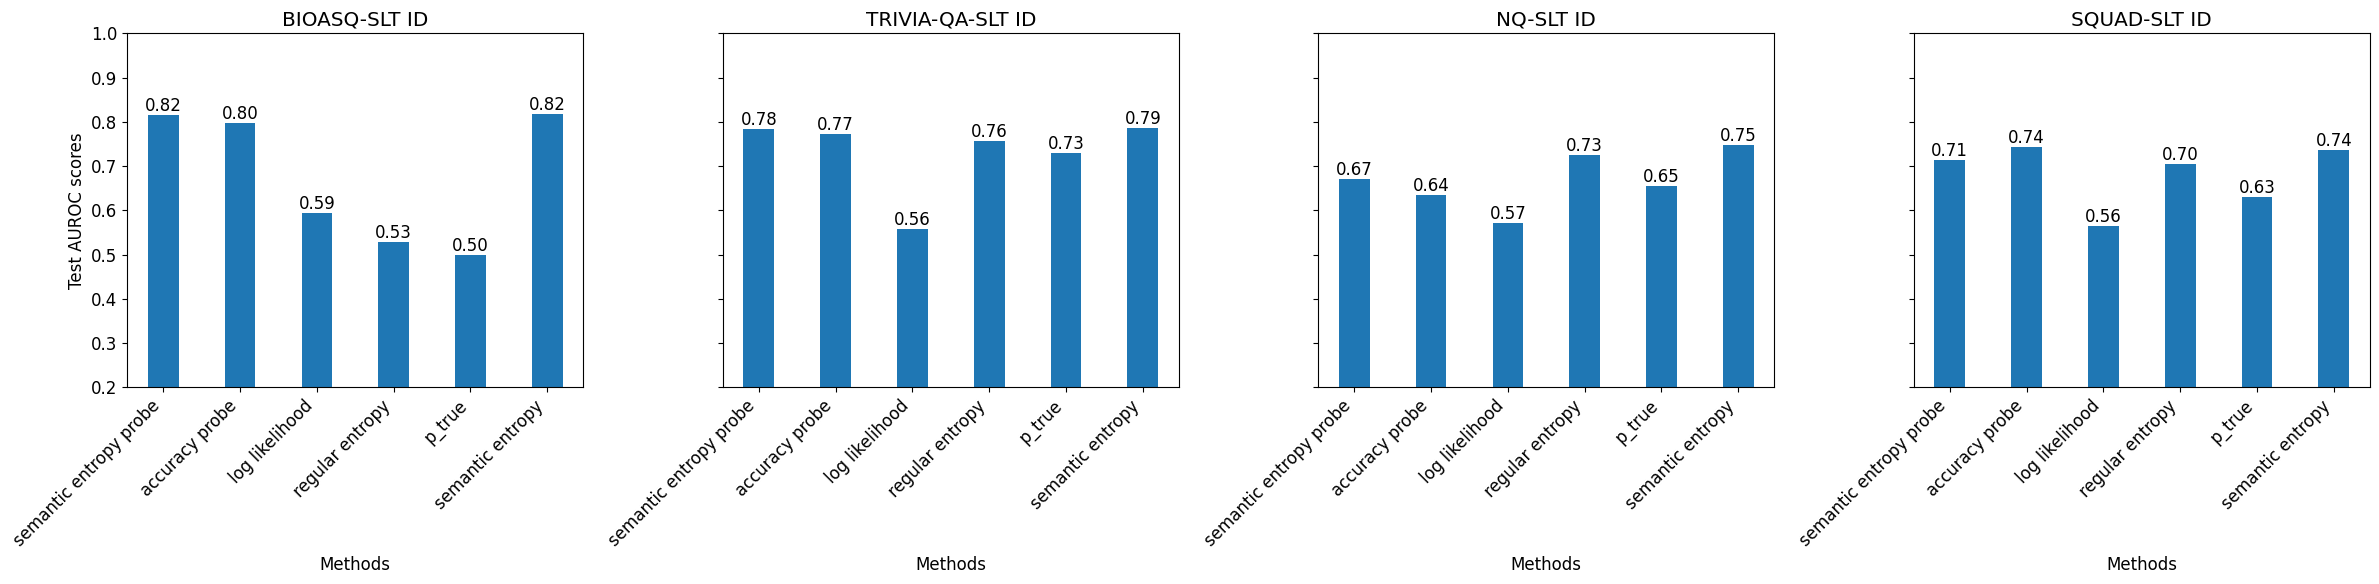

In [35]:
# plot performances
def plot_performance_barplots(Ds, types=['ood', 'id']):
    n = len(Ds)
    for type_ in types:
        fig, axes = plt.subplots(1, n, figsize=(n * 6, 6), sharey=True)
        
        for i, (D, ax) in enumerate(zip(Ds, axes)):
            x_labels = ['semantic entropy probe', 'accuracy probe', 'log likelihood', 'regular entropy', 'p_true', 'semantic entropy']

            if type_ == 'id':
                values = [D.isb_aucs[0]['mean'], D.isa_aucs[0]['mean'], D.loglik['mean'], D.baseline_re['mean'], 
                         0.5 if D.name == 'bioasq' else D.p_false_fixed['mean'], D.baseline_se['mean']]
            elif type_ == 'ood':
                values = [D.sep_ood_avg, D.ap_ood_avg, D.loglik['mean'], D.baseline_re['mean'], 
                          0.5 if D.name == 'bioasq' else D.p_false_fixed['mean'], D.baseline_se['mean']]
            else:
                return
                
            bars = ax.bar(x_labels, values, width=0.4, capsize=5) 
            ax.set_xlabel('Methods')
            if i == 0:  
                ax.set_ylabel('Test AUROC scores')
            ax.set_ylim(0.2, 1.0)
            ax.set_title(f"{D.name.upper()}-SLT {type_.upper()}")
            ax.set_xticklabels(x_labels, rotation=45, ha='right')
        
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
        
        plt.tight_layout()  
        save_fig(f'{type_}_performance_barplot')
        plt.show()

plot_performance_barplots(Ds)

## Save trained probes for inference


In [35]:
# save models to pickle for inference
Ds_save = ()
to_save_attrs = ['s_amodel', 's_bmodel', 't_amodel', 't_bmodel', 'sep_layer_range', 'ap_layer_range', 'name']

for D in Ds:
    D_save = {key: value for key, value in vars(D).items() if key in to_save_attrs}
    Ds_save += (D_save,)

path = f"{notebook_path}/models"
full_path = os.path.expanduser(path)
os.makedirs(full_path, exist_ok=True)

with open(f'{full_path}/{model_name}_inference.pkl', 'wb') as f:
    pickle.dump(Ds_save, f)